# How to select movies with all actors in as few movies as possible

It sometimes can feel overwhelming how many movies one has to watch to build a strong cinematographic culture. In 1999, the American Film Institute (AFI) defined a [list of 50 Hollywood legends](https://www.afi.com/afis-100-years-100-stars/) of the classical Hollywood era. While some of the actors in this list starred in multiple movies that would actually need to be seen, is it possible to define a strategy to cover all of these actors by watching as few movies as possible? 

This problem is actually known as the Set Cover problem. This problem attempts to find the smallest collection of sets which would cover the whole universe. Reformulated for our purpose, it is finding the smallest list of movies which would cover all the actors listed by the AFI.

The Set Cover problem is one of the fundamental algorithmic problems and has been shown to be NP-complete, meaning there is no known way to find a solution for this problem in an efficient way. Therefore, we will be using two approximation approaches to solve this problem: the greedy algorithm and an integer programming approximation.



## 1. Loading the data

In [1]:
from scipy.optimize import linprog
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

Below is the list of legend actors and actresses as defined by the American Film Institute.

In [2]:
afi_female_legends = [
              "Katharine Hepburn", "Bette Davis", "Audrey Hepburn", "Ingrid Bergman",
              "Greta Garbo", "Marilyn Monroe", "Elizabeth Taylor", "Judy Garland",
              "Marlene Dietrich", "Joan Crawford", "Barbara Stanwyck", "Claudette Colbert",
              "Grace Kelly", "Ginger Rogers", "Mae West", "Vivien Leigh",
              "Lillian Gish", "Shirley Temple", "Rita Hayworth", "Lauren Bacall", 
              "Sophia Loren", "Jean Harlow", "Carole Lombard", "Mary Pickford",
              "Ava Gardner"
]
afi_male_legends = [
                    "Humphrey Bogart", "Cary Grant", "James Stewart", "Marlon Brando",
                    "Fred Astaire", "Henry Fonda", "Clark Gable", "James Cagney",
                    "Spencer Tracy", "Charles Chaplin", "Gary Cooper", "Gregory Peck",
                    "John Wayne", "Laurence Olivier", "Gene Kelly", "Orson Welles",
                    "Kirk Douglas", "James Dean", "Burt Lancaster", "Groucho Marx",
                    "Buster Keaton", "Sidney Poitier", "Robert Mitchum", "Edward G. Robinson",
                    "William Holden"
]

legend_actors = afi_female_legends + afi_male_legends

The data comes from IMDB and links each actor to the movies it starred in.

In [3]:
%%capture
! wget "https://datasets.imdbws.com/title.principals.tsv.gz"
! wget "https://datasets.imdbws.com/title.basics.tsv.gz"
! wget "https://datasets.imdbws.com/name.basics.tsv.gz"

! gunzip title.principals.tsv.gz
! gunzip title.basics.tsv.gz
! gunzip name.basics.tsv.gz

In [4]:
cast = pd.read_csv("title.principals.tsv", sep="\t", na_values="\\N", keep_default_na=False, 
                   usecols=["tconst", "nconst", "category", "job"],
                   dtype={"tconst": str, "nconst": str, "category": str, "job": str})
titles = pd.read_csv("title.basics.tsv", sep="\t", na_values="\\N", keep_default_na=False,
                     usecols=["tconst", "primaryTitle", "startYear", "titleType"],
                    dtype={"tconst": str, "primaryTitle": str, "startYear": "Int64","titleType":str})
names = pd.read_csv("name.basics.tsv", sep="\t", na_values="\\N", keep_default_na=False,
                    usecols=["nconst", "primaryName"],
                   dtype={"nconst": str, "primaryName": str})

In [5]:
movie_titles = titles[titles.titleType == "movie"]

In [6]:
set_movies = pd.merge(
    pd.merge(
        names[names.primaryName.isin(legend_actors)],
        cast[cast.category.isin(["actor", "actress"])],
        on="nconst"
        ),
    titles[(titles.titleType == "movie") & (titles.startYear.notna())],
     on="tconst"
     )

In [7]:
print("All these actors have played in %i movies over their careers." %len(set_movies[["primaryTitle", "startYear"]].drop_duplicates()))

All these actors have played in 2257 movies over their careers.


## 2. Exploration

As a first step, we could quickly have a look at the gathered data and see how often these actors have actually played with each other.

In [8]:
combinations = set_movies[set_movies.groupby(["primaryTitle", "startYear"]).primaryName.transform("count") > 1]
one_each = set_movies.groupby("primaryName").first()
set_movies = pd.concat([combinations, one_each])
set_movies = set_movies.drop_duplicates(["primaryName", "category", "primaryTitle", "startYear"])
set_movies.head()

,nconst,primaryName,tconst,category,job,titleType,primaryTitle,startYear
0,nm0000001,Fred Astaire,tt0025164,actor,NaN,movie,The Gay Divorcee,1934
1,nm0001677,Ginger Rogers,tt0025164,actress,NaN,movie,The Gay Divorcee,1934
2,nm0000001,Fred Astaire,tt0026942,actor,NaN,movie,Roberta,1935
3,nm0001677,Ginger Rogers,tt0026942,actress,NaN,movie,Roberta,1935
4,nm0000001,Fred Astaire,tt0027125,actor,NaN,movie,Top Hat,1935


In [15]:
G=nx.Graph()
G.add_nodes_from(legend_actors)
actor_pairs = []
for movie in combinations.primaryTitle.unique():
    actors = list(combinations[combinations.primaryTitle == movie].primaryName)
    actor_pairs += list(itertools.combinations(actors, 2))
G.add_edges_from(actor_pairs)

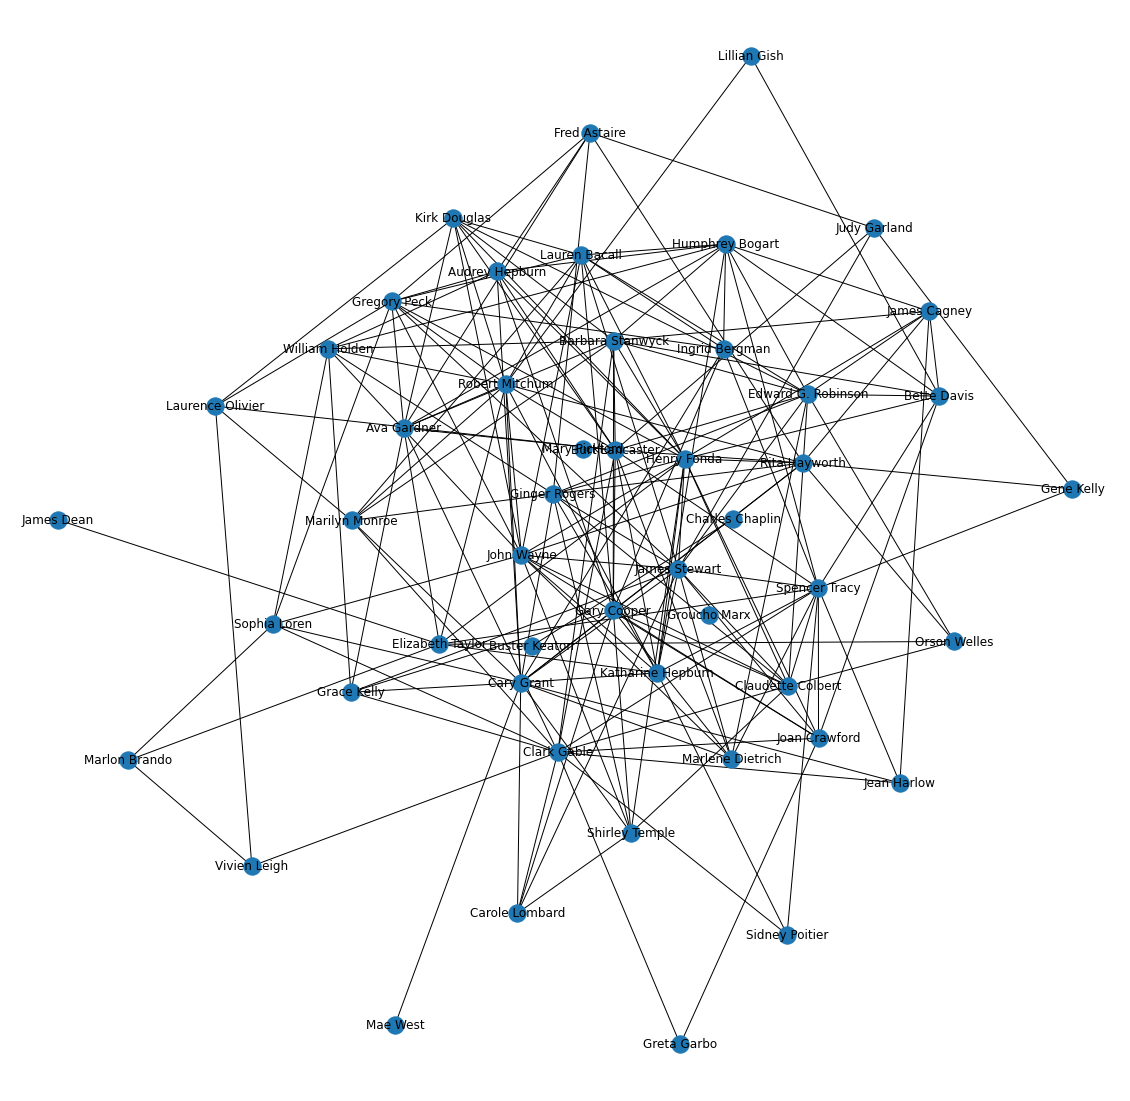

In [40]:
fig, ax = plt.subplots(figsize=(20,20))
nx.draw(G, with_labels=True, pos=nx.kamada_kawai_layout(G, pos=nx.random_layout(G, seed=2)), ax=ax)

In [12]:
print("We are considering %i movies for this problem by keeping only one movie for each actor where they appeared alone." 
      %len(set_movies[["primaryTitle", "startYear"]].drop_duplicates()))

We are considering 265 movies for this problem by keeping only one movie for each actor where they appeared alone.


In [13]:
def greedy_cover(movies):
    min_set = []
    while not movies.empty:
        title, year = movies.groupby(["primaryTitle", "startYear"]).primaryName.count().idxmax()
        min_set.append((title, year))
        actors_selected = movies[(movies.primaryTitle == title) & (movies.startYear == year)].primaryName
        movies = movies[~movies.primaryName.isin(actors_selected)]
    return min_set

In [14]:
min_set = greedy_cover(set_movies)
print("The greedy algorithm returned a min set of length %i." %len(min_set))
print(min_set)

The greedy algorithm returned a min set of length 24.
[('How the West Was Won', 1962), ('Boom Town', 1940), ('Key Largo', 1948), ('Monkey Business', 1952), ('Now and Forever', 1934), ('Seven Days in May', 1964), ('21 Days Together', 1940), ('A Countess from Hong Kong', 1967), ('Cover Girl', 1944), ('Easter Parade', 1948), ('Executive Suite', 1954), ('Genocide', 1982), ('Grand Hotel', 1932), ("Guess Who's Coming to Dinner", 1967), ('Jimmy the Gent', 1934), ('Limelight', 1952), ('The Night of the Hunter', 1955), ('Blonde Venus', 1932), ('Casablanca', 1942), ('Charade', 1963), ('China Seas', 1935), ('Giant', 1956), ('High Noon', 1952), ("I'm No Angel", 1933)]


In [15]:
movies_matrix_df = pd.concat([set_movies, pd.get_dummies(set_movies.primaryName)], axis=1)
movies_matrix_df = movies_matrix_df.groupby(["primaryTitle", "startYear"]).sum()
movies_matrix_df.head()

,,Audrey Hepburn,Ava Gardner,Barbara Stanwyck,Bette Davis,Burt Lancaster,Buster Keaton,Carole Lombard,Cary Grant,Charles Chaplin,Clark Gable,Claudette Colbert,Edward G. Robinson,Elizabeth Taylor,Fred Astaire,Gary Cooper,Gene Kelly,Ginger Rogers,Grace Kelly,Gregory Peck,Greta Garbo,Henry Fonda,Humphrey Bogart,Ingrid Bergman,James Cagney,James Dean,James Stewart,Jean Harlow,Joan Crawford,John Wayne,Judy Garland,Katharine Hepburn,Kirk Douglas,Lauren Bacall,Laurence Olivier,Lillian Gish,Mae West,Marilyn Monroe,Marlene Dietrich,Marlon Brando,Orson Welles,Rita Hayworth,Robert Mitchum,Shirley Temple,Sidney Poitier,Sophia Loren,Spencer Tracy,Vivien Leigh,William Holden
primaryTitle,startYear,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"20,000 Years in Sing Sing",1932,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
21 Days Together,1940,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
A Child Is Waiting,1963,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A Countess from Hong Kong,1967,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
A Streetcar Named Desire,1951,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [16]:
movies_matrix = movies_matrix_df.to_numpy().T

In [17]:
n_actors, n_movies = movies_matrix.shape

In [18]:
c = np.ones(n_movies)
A_ub = -1 * movies_matrix
b_ub = -1 * np.ones(n_actors)
l = np.zeros(n_movies)
u = np.ones(n_movies)
res = linprog(c=c, A_ub=A_ub, b_ub=b_ub, bounds=(0, 1))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [32]:
rounded_solution = movies_matrix_df.iloc[res.x > 0.5]
actors_covered = rounded_solution.sum(axis=0).sum()

print("The approximation of the Integer Linear Program returned a cover of %i actors with %i movies." %(actors_covered, len(rounded_solution)))

The approximation of the Integer Linear Program returned a cover of 41 actors with 17 movies.


In [20]:
movies_matrix_df.iloc[res.x > 0.5]

,,Audrey Hepburn,Ava Gardner,Barbara Stanwyck,Bette Davis,Burt Lancaster,Buster Keaton,Carole Lombard,Cary Grant,Charles Chaplin,Clark Gable,Claudette Colbert,Edward G. Robinson,Elizabeth Taylor,Fred Astaire,Gary Cooper,Gene Kelly,Ginger Rogers,Grace Kelly,Gregory Peck,Greta Garbo,Henry Fonda,Humphrey Bogart,Ingrid Bergman,James Cagney,James Dean,James Stewart,Jean Harlow,Joan Crawford,John Wayne,Judy Garland,Katharine Hepburn,Kirk Douglas,Lauren Bacall,Laurence Olivier,Lillian Gish,Mae West,Marilyn Monroe,Marlene Dietrich,Marlon Brando,Orson Welles,Rita Hayworth,Robert Mitchum,Shirley Temple,Sidney Poitier,Sophia Loren,Spencer Tracy,Vivien Leigh,William Holden
primaryTitle,startYear,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A Countess from Hong Kong,1967,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
Clash by Night,1952,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Giant,1956,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Grand Hotel,1932,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Guess Who's Coming to Dinner,1967,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
How the West Was Won,1962,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Limelight,1952,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Manpower,1941,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
Mogambo,1953,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
